In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from IPython.display import display, Markdown

skip_plots = True

Define the bounds of our data:
- Weights
- Indexes corresponding to weights for easier lookup
- Altitudes
- Indexes corresponding to altitudes for easier lookup
- Number of points in the linspaces used for fitting and plotting

In [2]:
weights         = [140,  150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290]
weights_index   = [  0,    1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15]
alts            = [250,  270, 290, 310, 330, 350, 370, 390, 410, 430]
alts_index      = [  0,    1,   2,   3,   4,   5,   6,   7,   8,   9]
ext_alts        = [110, 130, 150, 170, 190, 210, 230]
ext_alts_index  = [  0,   1,   2,   3,   4,   5,   6]
tip_tanks       = [ 60,   90]
tip_tanks_index = [  0,    1]
points_for_fit  = 1000

Transform functions for altitudes, weights, and mach to their respective indices and back.

In [3]:
def weight2index(weight: int) -> int:
  """Return the weight as a weight index."""
  return int((weight - 140) / 10)

def index2weight(index: int) -> int:
  """Return the weight index as a weight."""
  return weights[index]

def alt2index(alt: int) -> int:
  """Return the altitude as an altitude index."""
  return int((alt - 250) / 20)

def index2alt(index: int) -> int:
  """Return the altitude index as an altitude."""
  return alts[index]

def mach2index(mach: float) -> int:
  """Return the mach as a mach index"""
  if mach == 60: return 0
  if mach == 90: return 1
  return -1

def index2mach(index: int) -> float:
  """Return the mach index as a mach"""
  return tip_tanks[index]

def tip2mach(tip: int) -> float:
  """Return old name for tip"""
  if tip == 60: return 0.85
  if tip == 90: return 0.87
  return -1

Very basic IAS to TAS conversion based on a speed gain of 2% per 1000ft.

In [4]:
def ias2tas(ias: int, alt: int) -> float:
  """Return TAS from IAS and altitude."""
  return ias + (alt/10.0 * (ias * 0.02))

MMO mapping for altitudes based on the 320/365 limit

In [5]:
def alt2mmo60(alt: int) -> float:
  """Return MMO based on altitude <60% tip tank"""
  dict = {
    110: 0.587,
    130: 0.608,
    150: 0.631,
    170: 0.655,
    190: 0.680,
    210: 0.706,
    230: 0.733,
    250: 0.761,
    270: 0.791,
    290: 0.822,
    310: 0.850,
    330: 0.850,
    350: 0.850,
    370: 0.850,
    390: 0.850,
    410: 0.850,
    430: 0.850,
  }
  return dict[alt]

def alt2mmo90(alt: int) -> float:
  """Return MMO based on altitude >90% tip tank"""
  dict = {
    110: 0.667,
    130: 0.691,
    150: 0.716,
    170: 0.742,
    190: 0.770,
    210: 0.798,
    230: 0.828,
    250: 0.859,
    270: 0.870,
    290: 0.870,
    310: 0.870,
    330: 0.870,
    350: 0.870,
    370: 0.870,
    390: 0.870,
    410: 0.870,
    430: 0.870,
  }
  return dict[alt]

Parsing function to read in the CRZ PERF data files and construct a key value list for all known tables.

See `Format description.md` for a description of the file format.

In [6]:
matrix = {}

def parseFile(file_path: str) -> dict:
  """
  Parse file and return as matrix.

  Matrix has altitude keys and (Fuel Flow, IAS, mach) as values
  """
  matrix = {}
  file = open(file_path, 'r')
  lines = file.readlines()
  
  count = 0
  for line in lines:
    count += 1
    if count == 1:
      continue
    fields = line.split(";")
    alt = int(fields[0]) / 100
    ff = [int(item.strip()) for item in fields[1].split(",")]
    ias = [int(item.strip()) for item in fields[2].split(",")]
    mach = [float(item.strip()) for item in fields[3].split(",")]

    inner = {}
    for i in range(len(ff)):
      _ias = ias[i] if len(ias) > 1 else ias[0]
      _mach = mach[i] if len(mach) > 1 else mach[0]
      inner[weights[i]] = (ff[i], _ias, _mach)
    matrix[alt] = inner
  return matrix

def parseCSV(file_path: str) -> tuple[np.ndarray, np.ndarray]:
  x = []
  y = []

  file = open(file_path, 'r')
  lines = file.readlines()
  for line in lines:
    fields = line.split(",")
    average = (float(fields[0]) + float(fields[1])) / 2
    # We don't really care for anything other than 90 to 60
    # so we filter them out to have less data to slog through
    if average > 91 or average < 59: continue
    x.append(float(fields[2]))
    y.append(average)
  return np.array(x), np.array(y)

matrix["LRC"] = parseFile("../data/LRC.data")
matrix[82] = parseFile("../data/.82.data")
matrix[83] = parseFile("../data/.83.data")
matrix[84] = parseFile("../data/.84.data")


Basic parametrized functions used for the fitting.

In [7]:
def func_quad(x: np.ndarray, a: float, b: float, c: float) -> np.ndarray:
  """Return f(x) = ax^2 + bx + c."""
  return a * x**2 + b * x + c

def func_root(x: np.ndarray, a: float, b: float, c: float) -> np.ndarray:
  """Return f(x) = a*sqrt(x) + bx + c."""
  return a * np.sqrt(x) + b * x + c

def func_lin(x: np.ndarray, a: float, b: float) -> np.ndarray:
  """Return f(x) = a*x + b."""
  return a * x + b

Quick lookup of $LRC mach$ from our matrix.

In [8]:
def get_lrc_mach(weight: int, alt: int) -> float:
  """Return LRC mach at given altitude and weight."""
  return matrix["LRC"][alt][weight][2]

Generate "base" lists.

Base lists are extracted from the matrix for a given weight, altitude, and expected $MRC mach$.

Returned values are base lists for mach, mileage, colour (for the plot). Additional returned value is the $MRC mileage$ and $mMRC mach$.

$MRC mileage$ is calculated as the value required to get $LRC mileage$ if $LRC mileage$ is a $1\%$ drop from $MRC mileage$.

In [9]:
def generate_base_lists(weight: int, alt: int, mrc_mach: float) -> tuple[np.ndarray, np.ndarray, list[str], float, float]:
  """
  For a given weight, altitude, and MRC mach, return tuple containing
  - mach_base: [MRC mach, LRC mach, .82, .83, .84]
  - mileage_base: [MRC mileage, LRC mileage, .82 mileage, .83 mileage, .84 mileage]
  - col: Colour list for plotting, green is MRC; orange is LRC; .82, .83, .84 are blue; unknown are red
  - mrc_mileage: Calculated MRC mileage
  - mrc_mach: Pass through of MRC mach
  """
  raw = []
  col = []
  try:
    for spd in range(82, 85):
      pt = matrix[spd][alt][weight]
      raw.append((pt[0], ias2tas(pt[1], alt), pt[2]))
  except KeyError:
    pass

  lrc = matrix["LRC"][alt][weight]
  raw.append((lrc[0], ias2tas(lrc[1], alt), lrc[2], "LRC"))
  raw.sort(key=lambda i: i[2])

  spd_base = np.array([x[1] for x in raw])
  ff_base = np.array([x[0] * 3 for x in raw])
  mileage_base = spd_base / ff_base * 1000
  index = next((i for i, item in enumerate(raw) if len(item) == 4 and item[3] == 'LRC'), -10)
  lrc_mileage = mileage_base[index]
  mrc_mileage = lrc_mileage * 100.0/99.0

  raw.append((-1, -1, mrc_mach, "MRC"))
  raw.sort(key=lambda i: i[2])
  for i in range(len(raw)):
     if len(raw[i]) == 4 and raw[i][3] == "MRC":
        mileage_base = np.insert(mileage_base, i, mrc_mileage)
        break

  for x in raw:
    if len(x) < 4:
      col.append("blue")
    elif x[3] == "MRC":
      col.append("green")
    elif x[3] == "LRC":
      col.append("orange")
    else:
      col.append("red")

  mach_base = np.array([x[2] for x in raw])
  return mach_base, mileage_base, col, mrc_mileage, mrc_mach

Iteratively generate potential $MRC mach$ numbers for a given weight and altitude.

Use $MRC mach$, $LRC mach$, $.82$, $.83$, and $.84$ as the $x$ and mileage as the $y$ to fit a quadratic function.

Returned values are the $MRC mach$ value that has the lowest absolute error to the `max()` of the fitted function, the x axis linspace, and the corresponding fitted function.

Optionally plot all generate curves.

Optionally print altitude, weight, $MRC mach$, calculated $MRC mileage$, `max()` $MRC mileage$, and the absolute difference of the latter two.

In [10]:
def find_best_mrc_mach(weight: int, alt: int, show_intermediate_graphs: bool = False, debug_output: bool = False) -> tuple[float, np.ndarray, np.ndarray]:
  """
  For a given weight and altitude, return tuple containing
  - best_mrc_mach: MRC mach closest to the max() of the mach/mileage curve
  - x: x axis values for the mach/mileage curve
  - best_func: mach/mileage curve

  Optional parameters:
  - show_intermediate_graphs: Default False. Used to plot all curves.
  - debug_output: Default False. Used for debug
  """
  lrc_mach = get_lrc_mach(weight, alt)
  rng = np.linspace(lrc_mach - 0.1, lrc_mach, 100, False)
  best_mrc_mach = 0
  best_func = 0
  last_mrc_mileage_error = 10000

  for mrc_mach in rng:
    mach, mileage, colour, mrc_mileage, _ = generate_base_lists(weight, alt, mrc_mach)
    x = np.linspace(mrc_mach - 0.1, 0.95, points_for_fit)

    popt, _ = sp.optimize.curve_fit(func_quad, mach, mileage, maxfev=100000)
    mileage_mach_func = func_quad(x, *popt)

    if debug_output:
      print(f"{alt=}, {weight=}, {mrc_mach=}", mrc_mileage, max(mileage_mach_func), abs(mrc_mileage - max(mileage_mach_func)))

    if abs(mrc_mileage - max(mileage_mach_func)) < last_mrc_mileage_error:
      last_mrc_mileage_error = abs(mrc_mileage - max(mileage_mach_func))
      best_mrc_mach = round(mrc_mach, 3)
      best_func = mileage_mach_func
    else:
      return best_mrc_mach, x, best_func

    if show_intermediate_graphs and not skip_plots:
      plt.figure(figsize=(20,10))
      plt.title(f"mach/Mileage for {weight=} and {mrc_mach=}")
      plt.plot(x, mileage_mach_func)
      plt.scatter(mach, mileage, c=colour)
      plt.show()

Generate all curves for all weight and altitude combinations.

Use the mach/mileage curves to generate CI/mach curves for all weight and altitude combinations by fitting a root function using $0$, $200$, and $999$ as the $x$ and $MRC mach$, $LRC mach$, and $0.85$ as the corresponding $y$.

In [11]:
curves = []
for tips in tip_tanks:
  _curves = []
  for alt in alts:
    __curves = []
    for weight in weights:
      try:
        lrc_mach = get_lrc_mach(weight, alt)
        best_mrc_mach, x, mileage_mach_func = find_best_mrc_mach(weight, alt)
        display(Markdown(f"**Found: {best_mrc_mach} MRC and {lrc_mach} LRC**"))

        _mach, mileage, colour, mrc_mileage, mrc_mach = generate_base_lists(weight, alt, best_mrc_mach)

        if not skip_plots:
          plt.figure(figsize=(20,10))

          plt.subplot(1, 2, 1)
          plt.title(f"mach/Mileage for {alt=}, {weight=}, {mrc_mach=}")
          plt.xlabel("mach")
          plt.ylabel("Mileage in nmi/1000kg")
          plt.plot(x, mileage_mach_func)
          plt.scatter(_mach, mileage, c=colour)

        mmo = alt2mmo60(alt) if tips == 60 else alt2mmo90(alt)
        if lrc_mach >= mmo:
          mmo = lrc_mach
        ci_mach_base = [best_mrc_mach, lrc_mach, mmo]
        ci_base = [0, 200, 999]
        x = np.linspace(0, 999, points_for_fit)

        popt, _ = sp.optimize.curve_fit(func_root, ci_base, ci_mach_base, maxfev=10000)
        ci_mach_func = func_root(x, *popt)

        if not skip_plots:
          plt.subplot(1, 2, 2)
          plt.title(f"CI/mach for {alt=}, {weight=}, {mrc_mach=}, {lrc_mach=} {tips=}%\nwill be truncated during output to MMO if above")
          plt.xlabel("CI")
          plt.ylabel("mach")
          plt.scatter(ci_base, ci_mach_base)
          plt.plot(x, ci_mach_func)
          plt.show()

        display(Markdown(f"**Sanity check: {ci_mach_func[0]} MRC and {round(ci_mach_func[int(points_for_fit / 1000) * 200], 3)} LRC**"))

        __curves.append((ci_mach_func, popt))
      except KeyError:
        pass
    _curves.append(__curves)
  curves.append(_curves)

**Found: 0.534 MRC and 0.615 LRC**

C:\Users\llego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


**Sanity check: 0.534 MRC and 0.615 LRC**

**Found: 0.55 MRC and 0.633 LRC**

**Sanity check: 0.55 MRC and 0.633 LRC**

**Found: 0.57 MRC and 0.653 LRC**

**Sanity check: 0.57 MRC and 0.653 LRC**

**Found: 0.591 MRC and 0.674 LRC**

**Sanity check: 0.591 MRC and 0.674 LRC**

**Found: 0.612 MRC and 0.694 LRC**

**Sanity check: 0.612 MRC and 0.694 LRC**

**Found: 0.634 MRC and 0.714 LRC**

**Sanity check: 0.634 MRC and 0.714 LRC**

**Found: 0.659 MRC and 0.734 LRC**

**Sanity check: 0.659 MRC and 0.734 LRC**

**Found: 0.695 MRC and 0.758 LRC**

**Sanity check: 0.695 MRC and 0.758 LRC**

**Found: 0.732 MRC and 0.781 LRC**

**Sanity check: 0.732 MRC and 0.781 LRC**

**Found: 0.762 MRC and 0.799 LRC**

**Sanity check: 0.762 MRC and 0.799 LRC**

**Found: 0.783 MRC and 0.812 LRC**

**Sanity check: 0.783 MRC and 0.812 LRC**

**Found: 0.798 MRC and 0.821 LRC**

**Sanity check: 0.798 MRC and 0.821 LRC**

**Found: 0.801 MRC and 0.824 LRC**

**Sanity check: 0.801 MRC and 0.824 LRC**

**Found: 0.806 MRC and 0.827 LRC**

**Sanity check: 0.806 MRC and 0.827 LRC**

**Found: 0.81 MRC and 0.829 LRC**

**Sanity check: 0.81 MRC and 0.829 LRC**

**Found: 0.812 MRC and 0.83 LRC**

**Sanity check: 0.812 MRC and 0.83 LRC**

**Found: 0.555 MRC and 0.639 LRC**

**Sanity check: 0.555 MRC and 0.639 LRC**

**Found: 0.577 MRC and 0.661 LRC**

**Sanity check: 0.577 MRC and 0.661 LRC**

**Found: 0.598 MRC and 0.683 LRC**

**Sanity check: 0.598 MRC and 0.683 LRC**

**Found: 0.623 MRC and 0.705 LRC**

**Sanity check: 0.623 MRC and 0.705 LRC**

**Found: 0.647 MRC and 0.727 LRC**

**Sanity check: 0.647 MRC and 0.727 LRC**

**Found: 0.683 MRC and 0.752 LRC**

**Sanity check: 0.683 MRC and 0.752 LRC**

**Found: 0.725 MRC and 0.778 LRC**

**Sanity check: 0.725 MRC and 0.778 LRC**

**Found: 0.759 MRC and 0.798 LRC**

**Sanity check: 0.759 MRC and 0.798 LRC**

**Found: 0.782 MRC and 0.812 LRC**

**Sanity check: 0.782 MRC and 0.812 LRC**

**Found: 0.798 MRC and 0.821 LRC**

**Sanity check: 0.798 MRC and 0.821 LRC**

**Found: 0.802 MRC and 0.825 LRC**

**Sanity check: 0.802 MRC and 0.825 LRC**

**Found: 0.807 MRC and 0.828 LRC**

**Sanity check: 0.807 MRC and 0.828 LRC**

**Found: 0.81 MRC and 0.83 LRC**

**Sanity check: 0.81 MRC and 0.83 LRC**

**Found: 0.81 MRC and 0.83 LRC**

**Sanity check: 0.81 MRC and 0.83 LRC**

**Found: 0.81 MRC and 0.831 LRC**

**Sanity check: 0.81 MRC and 0.831 LRC**

**Found: 0.814 MRC and 0.832 LRC**

**Sanity check: 0.814 MRC and 0.832 LRC**

**Found: 0.583 MRC and 0.668 LRC**

**Sanity check: 0.583 MRC and 0.668 LRC**

**Found: 0.606 MRC and 0.692 LRC**

**Sanity check: 0.606 MRC and 0.692 LRC**

**Found: 0.632 MRC and 0.716 LRC**

**Sanity check: 0.632 MRC and 0.716 LRC**

**Found: 0.667 MRC and 0.742 LRC**

**Sanity check: 0.667 MRC and 0.742 LRC**

**Found: 0.711 MRC and 0.77 LRC**

**Sanity check: 0.711 MRC and 0.77 LRC**

**Found: 0.75 MRC and 0.793 LRC**

**Sanity check: 0.75 MRC and 0.793 LRC**

**Found: 0.78 MRC and 0.811 LRC**

**Sanity check: 0.78 MRC and 0.811 LRC**

**Found: 0.795 MRC and 0.821 LRC**

**Sanity check: 0.795 MRC and 0.821 LRC**

**Found: 0.802 MRC and 0.825 LRC**

**Sanity check: 0.802 MRC and 0.825 LRC**

**Found: 0.803 MRC and 0.828 LRC**

**Sanity check: 0.803 MRC and 0.828 LRC**

**Found: 0.809 MRC and 0.83 LRC**

**Sanity check: 0.809 MRC and 0.83 LRC**

**Found: 0.809 MRC and 0.83 LRC**

**Sanity check: 0.809 MRC and 0.83 LRC**

**Found: 0.807 MRC and 0.831 LRC**

**Sanity check: 0.807 MRC and 0.831 LRC**

**Found: 0.811 MRC and 0.832 LRC**

**Sanity check: 0.811 MRC and 0.832 LRC**

**Found: 0.811 MRC and 0.833 LRC**

**Sanity check: 0.811 MRC and 0.833 LRC**

**Found: 0.816 MRC and 0.834 LRC**

**Sanity check: 0.816 MRC and 0.834 LRC**

**Found: 0.614 MRC and 0.7 LRC**

**Sanity check: 0.614 MRC and 0.7 LRC**

**Found: 0.647 MRC and 0.727 LRC**

**Sanity check: 0.647 MRC and 0.727 LRC**

**Found: 0.691 MRC and 0.757 LRC**

**Sanity check: 0.691 MRC and 0.757 LRC**

**Found: 0.737 MRC and 0.785 LRC**

**Sanity check: 0.737 MRC and 0.785 LRC**

**Found: 0.776 MRC and 0.808 LRC**

**Sanity check: 0.776 MRC and 0.808 LRC**

**Found: 0.795 MRC and 0.819 LRC**

**Sanity check: 0.795 MRC and 0.819 LRC**

**Found: 0.802 MRC and 0.825 LRC**

**Sanity check: 0.802 MRC and 0.825 LRC**

**Found: 0.809 MRC and 0.828 LRC**

**Sanity check: 0.809 MRC and 0.828 LRC**

**Found: 0.811 MRC and 0.83 LRC**

**Sanity check: 0.811 MRC and 0.83 LRC**

**Found: 0.811 MRC and 0.83 LRC**

**Sanity check: 0.811 MRC and 0.83 LRC**

**Found: 0.813 MRC and 0.831 LRC**

**Sanity check: 0.813 MRC and 0.831 LRC**

**Found: 0.812 MRC and 0.833 LRC**

**Sanity check: 0.812 MRC and 0.833 LRC**

**Found: 0.818 MRC and 0.834 LRC**

**Sanity check: 0.818 MRC and 0.834 LRC**

**Found: 0.813 MRC and 0.835 LRC**

**Sanity check: 0.813 MRC and 0.835 LRC**

**Found: 0.821 MRC and 0.835 LRC**

**Sanity check: 0.821 MRC and 0.835 LRC**

**Found: 0.821 MRC and 0.836 LRC**

**Sanity check: 0.821 MRC and 0.836 LRC**

**Found: 0.66 MRC and 0.737 LRC**

**Sanity check: 0.66 MRC and 0.737 LRC**

**Found: 0.712 MRC and 0.771 LRC**

**Sanity check: 0.712 MRC and 0.771 LRC**

**Found: 0.758 MRC and 0.798 LRC**

**Sanity check: 0.758 MRC and 0.798 LRC**

**Found: 0.786 MRC and 0.815 LRC**

**Sanity check: 0.786 MRC and 0.815 LRC**

**Found: 0.798 MRC and 0.824 LRC**

**Sanity check: 0.798 MRC and 0.824 LRC**

**Found: 0.805 MRC and 0.828 LRC**

**Sanity check: 0.805 MRC and 0.828 LRC**

**Found: 0.808 MRC and 0.83 LRC**

**Sanity check: 0.808 MRC and 0.83 LRC**

**Found: 0.807 MRC and 0.83 LRC**

**Sanity check: 0.807 MRC and 0.83 LRC**

**Found: 0.805 MRC and 0.832 LRC**

**Sanity check: 0.805 MRC and 0.832 LRC**

**Found: 0.81 MRC and 0.833 LRC**

**Sanity check: 0.81 MRC and 0.833 LRC**

**Found: 0.806 MRC and 0.834 LRC**

**Sanity check: 0.806 MRC and 0.834 LRC**

**Found: 0.808 MRC and 0.835 LRC**

**Sanity check: 0.808 MRC and 0.835 LRC**

**Found: 0.811 MRC and 0.835 LRC**

**Sanity check: 0.811 MRC and 0.835 LRC**

**Found: 0.807 MRC and 0.836 LRC**

**Sanity check: 0.807 MRC and 0.836 LRC**

**Found: 0.816 MRC and 0.837 LRC**

**Sanity check: 0.816 MRC and 0.837 LRC**

**Found: 0.729 MRC and 0.782 LRC**

**Sanity check: 0.729 MRC and 0.782 LRC**

**Found: 0.776 MRC and 0.809 LRC**

**Sanity check: 0.776 MRC and 0.809 LRC**

**Found: 0.796 MRC and 0.822 LRC**

**Sanity check: 0.796 MRC and 0.822 LRC**

**Found: 0.801 MRC and 0.827 LRC**

**Sanity check: 0.801 MRC and 0.827 LRC**

**Found: 0.805 MRC and 0.83 LRC**

**Sanity check: 0.805 MRC and 0.83 LRC**

**Found: 0.806 MRC and 0.83 LRC**

**Sanity check: 0.806 MRC and 0.83 LRC**

**Found: 0.802 MRC and 0.832 LRC**

**Sanity check: 0.802 MRC and 0.832 LRC**

**Found: 0.807 MRC and 0.833 LRC**

**Sanity check: 0.807 MRC and 0.833 LRC**

**Found: 0.802 MRC and 0.834 LRC**

**Sanity check: 0.802 MRC and 0.834 LRC**

**Found: 0.805 MRC and 0.835 LRC**

**Sanity check: 0.805 MRC and 0.835 LRC**

**Found: 0.811 MRC and 0.836 LRC**

**Sanity check: 0.811 MRC and 0.836 LRC**

**Found: 0.8 MRC and 0.837 LRC**

**Sanity check: 0.8 MRC and 0.837 LRC**

**Found: 0.8 MRC and 0.837 LRC**

**Sanity check: 0.8 MRC and 0.837 LRC**

**Found: 0.785 MRC and 0.814 LRC**

**Sanity check: 0.785 MRC and 0.814 LRC**

**Found: 0.798 MRC and 0.824 LRC**

**Sanity check: 0.798 MRC and 0.824 LRC**

**Found: 0.808 MRC and 0.829 LRC**

**Sanity check: 0.808 MRC and 0.829 LRC**

**Found: 0.806 MRC and 0.83 LRC**

**Sanity check: 0.806 MRC and 0.83 LRC**

**Found: 0.81 MRC and 0.831 LRC**

**Sanity check: 0.81 MRC and 0.831 LRC**

**Found: 0.809 MRC and 0.833 LRC**

**Sanity check: 0.809 MRC and 0.833 LRC**

**Found: 0.813 MRC and 0.834 LRC**

**Sanity check: 0.813 MRC and 0.834 LRC**

**Found: 0.82 MRC and 0.835 LRC**

**Sanity check: 0.82 MRC and 0.835 LRC**

**Found: 0.81 MRC and 0.836 LRC**

**Sanity check: 0.81 MRC and 0.836 LRC**

**Found: 0.815 MRC and 0.837 LRC**

**Sanity check: 0.815 MRC and 0.837 LRC**

**Found: 0.811 MRC and 0.837 LRC**

**Sanity check: 0.811 MRC and 0.837 LRC**

**Found: 0.804 MRC and 0.827 LRC**

**Sanity check: 0.804 MRC and 0.827 LRC**

**Found: 0.809 MRC and 0.83 LRC**

**Sanity check: 0.809 MRC and 0.83 LRC**

**Found: 0.804 MRC and 0.831 LRC**

**Sanity check: 0.804 MRC and 0.831 LRC**

**Found: 0.81 MRC and 0.832 LRC**

**Sanity check: 0.81 MRC and 0.832 LRC**

**Found: 0.807 MRC and 0.834 LRC**

**Sanity check: 0.807 MRC and 0.834 LRC**

**Found: 0.809 MRC and 0.835 LRC**

**Sanity check: 0.809 MRC and 0.835 LRC**

**Found: 0.818 MRC and 0.836 LRC**

**Sanity check: 0.818 MRC and 0.836 LRC**

**Found: 0.804 MRC and 0.837 LRC**

**Sanity check: 0.804 MRC and 0.837 LRC**

**Found: 0.801 MRC and 0.83 LRC**

**Sanity check: 0.801 MRC and 0.83 LRC**

**Found: 0.807 MRC and 0.832 LRC**

**Sanity check: 0.807 MRC and 0.832 LRC**

**Found: 0.804 MRC and 0.833 LRC**

**Sanity check: 0.804 MRC and 0.833 LRC**

**Found: 0.81 MRC and 0.835 LRC**

**Sanity check: 0.81 MRC and 0.835 LRC**

**Found: 0.8 MRC and 0.836 LRC**

**Sanity check: 0.8 MRC and 0.836 LRC**

**Found: 0.805 MRC and 0.837 LRC**

**Sanity check: 0.805 MRC and 0.837 LRC**

**Found: 0.8 MRC and 0.838 LRC**

**Sanity check: 0.8 MRC and 0.838 LRC**

**Found: 0.804 MRC and 0.832 LRC**

**Sanity check: 0.804 MRC and 0.832 LRC**

**Found: 0.798 MRC and 0.834 LRC**

**Sanity check: 0.798 MRC and 0.834 LRC**

**Found: 0.802 MRC and 0.835 LRC**

**Sanity check: 0.802 MRC and 0.835 LRC**

**Found: 0.791 MRC and 0.837 LRC**

**Sanity check: 0.791 MRC and 0.837 LRC**

**Found: 0.788 MRC and 0.837 LRC**

**Sanity check: 0.788 MRC and 0.837 LRC**

**Found: 0.534 MRC and 0.615 LRC**

**Sanity check: 0.534 MRC and 0.615 LRC**

**Found: 0.55 MRC and 0.633 LRC**

**Sanity check: 0.55 MRC and 0.633 LRC**

**Found: 0.57 MRC and 0.653 LRC**

**Sanity check: 0.57 MRC and 0.653 LRC**

**Found: 0.591 MRC and 0.674 LRC**

**Sanity check: 0.591 MRC and 0.674 LRC**

**Found: 0.612 MRC and 0.694 LRC**

**Sanity check: 0.612 MRC and 0.694 LRC**

**Found: 0.634 MRC and 0.714 LRC**

**Sanity check: 0.634 MRC and 0.714 LRC**

**Found: 0.659 MRC and 0.734 LRC**

**Sanity check: 0.659 MRC and 0.734 LRC**

**Found: 0.695 MRC and 0.758 LRC**

**Sanity check: 0.695 MRC and 0.758 LRC**

**Found: 0.732 MRC and 0.781 LRC**

**Sanity check: 0.732 MRC and 0.781 LRC**

**Found: 0.762 MRC and 0.799 LRC**

**Sanity check: 0.762 MRC and 0.799 LRC**

**Found: 0.783 MRC and 0.812 LRC**

**Sanity check: 0.783 MRC and 0.812 LRC**

**Found: 0.798 MRC and 0.821 LRC**

**Sanity check: 0.798 MRC and 0.821 LRC**

**Found: 0.801 MRC and 0.824 LRC**

**Sanity check: 0.801 MRC and 0.824 LRC**

**Found: 0.806 MRC and 0.827 LRC**

**Sanity check: 0.806 MRC and 0.827 LRC**

**Found: 0.81 MRC and 0.829 LRC**

**Sanity check: 0.81 MRC and 0.829 LRC**

**Found: 0.812 MRC and 0.83 LRC**

**Sanity check: 0.812 MRC and 0.83 LRC**

**Found: 0.555 MRC and 0.639 LRC**

**Sanity check: 0.555 MRC and 0.639 LRC**

**Found: 0.577 MRC and 0.661 LRC**

**Sanity check: 0.577 MRC and 0.661 LRC**

**Found: 0.598 MRC and 0.683 LRC**

**Sanity check: 0.598 MRC and 0.683 LRC**

**Found: 0.623 MRC and 0.705 LRC**

**Sanity check: 0.623 MRC and 0.705 LRC**

**Found: 0.647 MRC and 0.727 LRC**

**Sanity check: 0.647 MRC and 0.727 LRC**

**Found: 0.683 MRC and 0.752 LRC**

**Sanity check: 0.683 MRC and 0.752 LRC**

**Found: 0.725 MRC and 0.778 LRC**

**Sanity check: 0.725 MRC and 0.778 LRC**

**Found: 0.759 MRC and 0.798 LRC**

**Sanity check: 0.759 MRC and 0.798 LRC**

**Found: 0.782 MRC and 0.812 LRC**

**Sanity check: 0.782 MRC and 0.812 LRC**

**Found: 0.798 MRC and 0.821 LRC**

**Sanity check: 0.798 MRC and 0.821 LRC**

**Found: 0.802 MRC and 0.825 LRC**

**Sanity check: 0.802 MRC and 0.825 LRC**

**Found: 0.807 MRC and 0.828 LRC**

**Sanity check: 0.807 MRC and 0.828 LRC**

**Found: 0.81 MRC and 0.83 LRC**

**Sanity check: 0.81 MRC and 0.83 LRC**

**Found: 0.81 MRC and 0.83 LRC**

**Sanity check: 0.81 MRC and 0.83 LRC**

**Found: 0.81 MRC and 0.831 LRC**

**Sanity check: 0.81 MRC and 0.831 LRC**

**Found: 0.814 MRC and 0.832 LRC**

**Sanity check: 0.814 MRC and 0.832 LRC**

**Found: 0.583 MRC and 0.668 LRC**

**Sanity check: 0.583 MRC and 0.668 LRC**

**Found: 0.606 MRC and 0.692 LRC**

**Sanity check: 0.606 MRC and 0.692 LRC**

**Found: 0.632 MRC and 0.716 LRC**

**Sanity check: 0.632 MRC and 0.716 LRC**

**Found: 0.667 MRC and 0.742 LRC**

**Sanity check: 0.667 MRC and 0.742 LRC**

**Found: 0.711 MRC and 0.77 LRC**

**Sanity check: 0.711 MRC and 0.77 LRC**

**Found: 0.75 MRC and 0.793 LRC**

**Sanity check: 0.75 MRC and 0.793 LRC**

**Found: 0.78 MRC and 0.811 LRC**

**Sanity check: 0.78 MRC and 0.811 LRC**

**Found: 0.795 MRC and 0.821 LRC**

**Sanity check: 0.795 MRC and 0.821 LRC**

**Found: 0.802 MRC and 0.825 LRC**

**Sanity check: 0.802 MRC and 0.825 LRC**

**Found: 0.803 MRC and 0.828 LRC**

**Sanity check: 0.803 MRC and 0.828 LRC**

**Found: 0.809 MRC and 0.83 LRC**

**Sanity check: 0.809 MRC and 0.83 LRC**

**Found: 0.809 MRC and 0.83 LRC**

**Sanity check: 0.809 MRC and 0.83 LRC**

**Found: 0.807 MRC and 0.831 LRC**

**Sanity check: 0.807 MRC and 0.831 LRC**

**Found: 0.811 MRC and 0.832 LRC**

**Sanity check: 0.811 MRC and 0.832 LRC**

**Found: 0.811 MRC and 0.833 LRC**

**Sanity check: 0.811 MRC and 0.833 LRC**

**Found: 0.816 MRC and 0.834 LRC**

**Sanity check: 0.816 MRC and 0.834 LRC**

**Found: 0.614 MRC and 0.7 LRC**

**Sanity check: 0.614 MRC and 0.7 LRC**

**Found: 0.647 MRC and 0.727 LRC**

**Sanity check: 0.647 MRC and 0.727 LRC**

**Found: 0.691 MRC and 0.757 LRC**

**Sanity check: 0.691 MRC and 0.757 LRC**

**Found: 0.737 MRC and 0.785 LRC**

**Sanity check: 0.737 MRC and 0.785 LRC**

**Found: 0.776 MRC and 0.808 LRC**

**Sanity check: 0.776 MRC and 0.808 LRC**

**Found: 0.795 MRC and 0.819 LRC**

**Sanity check: 0.795 MRC and 0.819 LRC**

**Found: 0.802 MRC and 0.825 LRC**

**Sanity check: 0.802 MRC and 0.825 LRC**

**Found: 0.809 MRC and 0.828 LRC**

**Sanity check: 0.809 MRC and 0.828 LRC**

**Found: 0.811 MRC and 0.83 LRC**

**Sanity check: 0.811 MRC and 0.83 LRC**

**Found: 0.811 MRC and 0.83 LRC**

**Sanity check: 0.811 MRC and 0.83 LRC**

**Found: 0.813 MRC and 0.831 LRC**

**Sanity check: 0.813 MRC and 0.831 LRC**

**Found: 0.812 MRC and 0.833 LRC**

**Sanity check: 0.812 MRC and 0.833 LRC**

**Found: 0.818 MRC and 0.834 LRC**

**Sanity check: 0.818 MRC and 0.834 LRC**

**Found: 0.813 MRC and 0.835 LRC**

**Sanity check: 0.813 MRC and 0.835 LRC**

**Found: 0.821 MRC and 0.835 LRC**

**Sanity check: 0.821 MRC and 0.835 LRC**

**Found: 0.821 MRC and 0.836 LRC**

**Sanity check: 0.821 MRC and 0.836 LRC**

**Found: 0.66 MRC and 0.737 LRC**

**Sanity check: 0.66 MRC and 0.737 LRC**

**Found: 0.712 MRC and 0.771 LRC**

**Sanity check: 0.712 MRC and 0.771 LRC**

**Found: 0.758 MRC and 0.798 LRC**

**Sanity check: 0.758 MRC and 0.798 LRC**

**Found: 0.786 MRC and 0.815 LRC**

**Sanity check: 0.786 MRC and 0.815 LRC**

**Found: 0.798 MRC and 0.824 LRC**

**Sanity check: 0.798 MRC and 0.824 LRC**

**Found: 0.805 MRC and 0.828 LRC**

**Sanity check: 0.805 MRC and 0.828 LRC**

**Found: 0.808 MRC and 0.83 LRC**

**Sanity check: 0.808 MRC and 0.83 LRC**

**Found: 0.807 MRC and 0.83 LRC**

**Sanity check: 0.807 MRC and 0.83 LRC**

**Found: 0.805 MRC and 0.832 LRC**

**Sanity check: 0.805 MRC and 0.832 LRC**

**Found: 0.81 MRC and 0.833 LRC**

**Sanity check: 0.81 MRC and 0.833 LRC**

**Found: 0.806 MRC and 0.834 LRC**

**Sanity check: 0.806 MRC and 0.834 LRC**

**Found: 0.808 MRC and 0.835 LRC**

**Sanity check: 0.808 MRC and 0.835 LRC**

**Found: 0.811 MRC and 0.835 LRC**

**Sanity check: 0.811 MRC and 0.835 LRC**

**Found: 0.807 MRC and 0.836 LRC**

**Sanity check: 0.807 MRC and 0.836 LRC**

**Found: 0.816 MRC and 0.837 LRC**

**Sanity check: 0.816 MRC and 0.837 LRC**

**Found: 0.729 MRC and 0.782 LRC**

**Sanity check: 0.729 MRC and 0.782 LRC**

**Found: 0.776 MRC and 0.809 LRC**

**Sanity check: 0.776 MRC and 0.809 LRC**

**Found: 0.796 MRC and 0.822 LRC**

**Sanity check: 0.796 MRC and 0.822 LRC**

**Found: 0.801 MRC and 0.827 LRC**

**Sanity check: 0.801 MRC and 0.827 LRC**

**Found: 0.805 MRC and 0.83 LRC**

**Sanity check: 0.805 MRC and 0.83 LRC**

**Found: 0.806 MRC and 0.83 LRC**

**Sanity check: 0.806 MRC and 0.83 LRC**

**Found: 0.802 MRC and 0.832 LRC**

**Sanity check: 0.802 MRC and 0.832 LRC**

**Found: 0.807 MRC and 0.833 LRC**

**Sanity check: 0.807 MRC and 0.833 LRC**

**Found: 0.802 MRC and 0.834 LRC**

**Sanity check: 0.802 MRC and 0.834 LRC**

**Found: 0.805 MRC and 0.835 LRC**

**Sanity check: 0.805 MRC and 0.835 LRC**

**Found: 0.811 MRC and 0.836 LRC**

**Sanity check: 0.811 MRC and 0.836 LRC**

**Found: 0.8 MRC and 0.837 LRC**

**Sanity check: 0.8 MRC and 0.837 LRC**

**Found: 0.8 MRC and 0.837 LRC**

**Sanity check: 0.8 MRC and 0.837 LRC**

**Found: 0.785 MRC and 0.814 LRC**

**Sanity check: 0.785 MRC and 0.814 LRC**

**Found: 0.798 MRC and 0.824 LRC**

**Sanity check: 0.798 MRC and 0.824 LRC**

**Found: 0.808 MRC and 0.829 LRC**

**Sanity check: 0.808 MRC and 0.829 LRC**

**Found: 0.806 MRC and 0.83 LRC**

**Sanity check: 0.806 MRC and 0.83 LRC**

**Found: 0.81 MRC and 0.831 LRC**

**Sanity check: 0.81 MRC and 0.831 LRC**

**Found: 0.809 MRC and 0.833 LRC**

**Sanity check: 0.809 MRC and 0.833 LRC**

**Found: 0.813 MRC and 0.834 LRC**

**Sanity check: 0.813 MRC and 0.834 LRC**

**Found: 0.82 MRC and 0.835 LRC**

**Sanity check: 0.82 MRC and 0.835 LRC**

**Found: 0.81 MRC and 0.836 LRC**

**Sanity check: 0.81 MRC and 0.836 LRC**

**Found: 0.815 MRC and 0.837 LRC**

**Sanity check: 0.815 MRC and 0.837 LRC**

**Found: 0.811 MRC and 0.837 LRC**

**Sanity check: 0.811 MRC and 0.837 LRC**

**Found: 0.804 MRC and 0.827 LRC**

**Sanity check: 0.804 MRC and 0.827 LRC**

**Found: 0.809 MRC and 0.83 LRC**

**Sanity check: 0.809 MRC and 0.83 LRC**

**Found: 0.804 MRC and 0.831 LRC**

**Sanity check: 0.804 MRC and 0.831 LRC**

**Found: 0.81 MRC and 0.832 LRC**

**Sanity check: 0.81 MRC and 0.832 LRC**

**Found: 0.807 MRC and 0.834 LRC**

**Sanity check: 0.807 MRC and 0.834 LRC**

**Found: 0.809 MRC and 0.835 LRC**

**Sanity check: 0.809 MRC and 0.835 LRC**

**Found: 0.818 MRC and 0.836 LRC**

**Sanity check: 0.818 MRC and 0.836 LRC**

**Found: 0.804 MRC and 0.837 LRC**

**Sanity check: 0.804 MRC and 0.837 LRC**

**Found: 0.801 MRC and 0.83 LRC**

**Sanity check: 0.801 MRC and 0.83 LRC**

**Found: 0.807 MRC and 0.832 LRC**

**Sanity check: 0.807 MRC and 0.832 LRC**

**Found: 0.804 MRC and 0.833 LRC**

**Sanity check: 0.804 MRC and 0.833 LRC**

**Found: 0.81 MRC and 0.835 LRC**

**Sanity check: 0.81 MRC and 0.835 LRC**

**Found: 0.8 MRC and 0.836 LRC**

**Sanity check: 0.8 MRC and 0.836 LRC**

**Found: 0.805 MRC and 0.837 LRC**

**Sanity check: 0.805 MRC and 0.837 LRC**

**Found: 0.8 MRC and 0.838 LRC**

**Sanity check: 0.8 MRC and 0.838 LRC**

**Found: 0.804 MRC and 0.832 LRC**

**Sanity check: 0.804 MRC and 0.832 LRC**

**Found: 0.798 MRC and 0.834 LRC**

**Sanity check: 0.798 MRC and 0.834 LRC**

**Found: 0.802 MRC and 0.835 LRC**

**Sanity check: 0.802 MRC and 0.835 LRC**

**Found: 0.791 MRC and 0.837 LRC**

**Sanity check: 0.791 MRC and 0.837 LRC**

**Found: 0.788 MRC and 0.837 LRC**

**Sanity check: 0.788 MRC and 0.837 LRC**

Diagnostic plots to see how the CI/mach curves change with altitude for a given weight.

In [12]:
if not skip_plots:
  x = np.linspace(0, 999, points_for_fit)

  for tips in tip_tanks_index:
    for weight in weights_index:
      plt.figure(figsize=(20,10))
      plt.title(f"CI/mach for weight={index2weight(weight)}, tip={index2mach(tips)}%")
      plt.xlabel("CI")
      plt.ylabel("mach")
      for alt in alts_index:
        try:
          plt.plot(x, curves[tips][alt][weight][0], label=f"alt={index2alt(alt)}")
        except IndexError:
          pass
      plt.legend()
      plt.show()

Diagnostic plot to see how linear $MRC mach$ is for all altitudes at a given weight.

In [13]:
if not skip_plots:
  x = np.linspace(250, 430, 10)

  for tips in tip_tanks_index:
    for weight in weights_index:
      plt.title(f"MRC at weight={index2weight(weight)}, tips={index2mach(tips)}%")
      plt.xlabel("Altitude in FL")
      plt.ylabel("mach")
      for alt in alts_index:
        try:
          plt.scatter(x[alt], curves[tips][alt][weight][0][0], label=f"alt={index2alt(alt)}")
        except IndexError:
          pass
      plt.legend()
      plt.show()

Total fuel to tip tank function

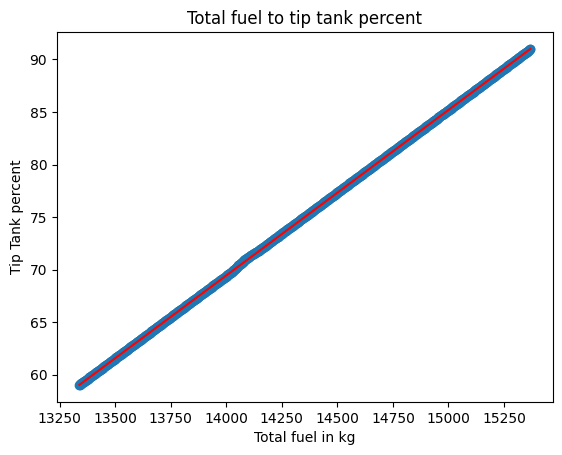

Parameters are [ 1.57613580e-02 -1.51221174e+02]


In [14]:
total2tip_x, total2tip_y = parseCSV("../data/md-11 tip to total 1_30h.csv")

popt, _ = sp.optimize.curve_fit(func_lin, total2tip_x, total2tip_y, maxfev=100000)
total_tip_func = func_lin(total2tip_x, *popt)

plt.title(f"Total fuel to tip tank percent")
plt.xlabel("Total fuel in kg")
plt.ylabel("Tip Tank percent")
plt.scatter(total2tip_x, total2tip_y)
plt.plot(total2tip_x, total_tip_func, c="r")
plt.show()

print("Parameters are", popt)

Output to files.

See `Format description.md` for a description of the file format.

In [15]:
for tips in tip_tanks_index:
  raw = open(f"curve_params_{index2mach(tips)}.data", "w")
  for alt in alts_index:
    _raw = []
    lut = open(f"ci2mach_{index2alt(alt)}_{index2mach(tips)}.data", "w")
    for weight in weights_index:
      try:
        current_list = curves[tips][alt][weight][0]
        mmo = curves[tips][alt][weight][0][999]
        lut.writelines(",".join(str(round(min(x, mmo), 3)) for x in current_list.tolist()) + "\n")
        _raw.append(','.join(str(x) for x in curves[tips][alt][weight][1].tolist()))
      except IndexError:
        pass
    lut.close()
    raw.writelines(";".join(_raw) + "\n")
  raw.close()

Header file

In [25]:
for tips in tip_tanks_index:
  lut = open(f"ci2mach_{tip2mach(index2mach(tips))}.h", "w")
  lut.writelines(f"#ifndef CI2MACH_{int(tip2mach(index2mach(tips)) * 100)}\n")
  lut.writelines(f"#define CI2MACH_{int(tip2mach(index2mach(tips)) * 100)}\n\n")

  lut.writelines("#ifndef NULL\n")
  lut.writelines("#define NULL 0\n")
  lut.writelines("#endif\n\n")

  lut.writelines(f"class CI2Mach_{int(tip2mach(index2mach(tips)) * 100)} {{\n")
  lut.writelines("public:\n")
  lut.writelines(f"  float values[{len(alts_index)}][{len(weights_index)}][1000] = {{\n")
  for alt in alts_index:
    lut.writelines("  {\n")
    for weight in weights_index:
      try:
        current_list = curves[tips][alt][weight][0]
        mmo = curves[tips][alt][weight][0][999]
        lut.writelines("    {" + ",".join("{:.3f}f".format(round(min(x, mmo), 3)) for x in current_list.tolist()) + "},\n")
      except IndexError:
        lut.writelines("    {" + ",".join(["-1".format(x) for x in range(0, 1000)]) + "},\n")
    lut.writelines("  },\n")
  lut.writelines("};\n};\n\n")

  lut.writelines(f"CI2Mach_{int(tip2mach(index2mach(tips)) * 100)}* ci2Mach_{int(tip2mach(index2mach(tips)) * 100)} = NULL;\n\n")
  lut.writelines(f"void init_ci2mach_{int(tip2mach(index2mach(tips)) * 100)}() {{\n")
  lut.writelines(f"  ci2Mach_{int(tip2mach(index2mach(tips)) * 100)} = new CI2Mach_{int(tip2mach(index2mach(tips)) * 100)}();\n")
  lut.writelines("}\n\n");

  lut.writelines(f"void cleanup_ci2mach_{int(tip2mach(index2mach(tips)) * 100)}() {{\n")
  lut.writelines(f"  if (ci2Mach_{int(tip2mach(index2mach(tips)) * 100)} != NULL) {{\n")
  lut.writelines(f"    delete ci2Mach_{int(tip2mach(index2mach(tips)) * 100)};\n")
  lut.writelines(f"    ci2Mach_{int(tip2mach(index2mach(tips)) * 100)} = NULL;\n")
  lut.writelines("  }\n}\n\n")

  lut.writelines("#endif")
  lut.close()


Demo area.

In [17]:
mach = mach2index(90) # 0.87
alt = 290
weight = 250
ci = 80

lut = curves[mach][alt2index(alt)][weight2index(weight)][0][ci]
params = curves[mach][alt2index(alt)][weight2index(weight)][1]
func = func_root(ci, *curves[mach][alt2index(alt)][weight2index(weight)][1])

print(f"{alt=}, {weight=}, {ci=}: {lut=}, {params=}, {func=}")

alt=290, weight=250, ci=80: lut=0.8210969019894392, params=array([1.12456109e-03, 2.54815227e-05, 8.09000000e-01]), func=0.8210969019894392
